## Time Series Analysis: Forecasting Regional Electrical Demand

### Steps

* Loading the Data
* Basic EDA
* Exploring Drift and Seasonality
* Modeling Seasonal Background Load
* Load forecasting

In [1]:
import datetime as dt
import numpy as np
import pandas as pd

from sklearn import base
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn import metrics

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
#!wget https://raw.githubusercontent.com/truggles/EIA_Cleaned_Hourly_Electricity_Demand_Data/master/data/release_2020_Oct/regions/NE.csv

In [3]:
df_NE = pd.read_csv('NE.csv')
df_NE.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43848 entries, 0 to 43847
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   date_time            43848 non-null  object 
 1   raw demand (MW)      43848 non-null  float64
 2   cleaned demand (MW)  43848 non-null  int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 1.0+ MB


In [4]:
df_NE.columns = df_NE.columns.str.replace(' ', '_').str.replace('(', '').str.replace(')', '')
df_NE['date_time'] = pd.to_datetime(df_NE['date_time'])
df_NE.head()

date_time  raw_demand_MW  cleaned_demand_MW
0 2015-07-02 00:00:00        17653.0              17653
1 2015-07-02 01:00:00        17286.0              17286
2 2015-07-02 02:00:00        16701.0              16701
3 2015-07-02 03:00:00        15220.0              15220
4 2015-07-02 04:00:00        13594.0              13594

In [5]:
df_NE.describe()

date_time  raw_demand_MW  cleaned_demand_MW
count                43848   43848.000000       43848.000000
mean   2017-12-31 11:30:00   13874.842501       13875.772099
min    2015-07-02 00:00:00       0.000000        8494.000000
25%    2016-09-30 17:45:00   12011.000000       12011.000000
50%    2017-12-31 11:30:00   13588.000000       13588.500000
75%    2019-04-02 05:15:00   15310.000000       15310.000000
max    2020-07-01 23:00:00   25763.000000       25763.000000
std                    NaN    2598.584172        2596.024883

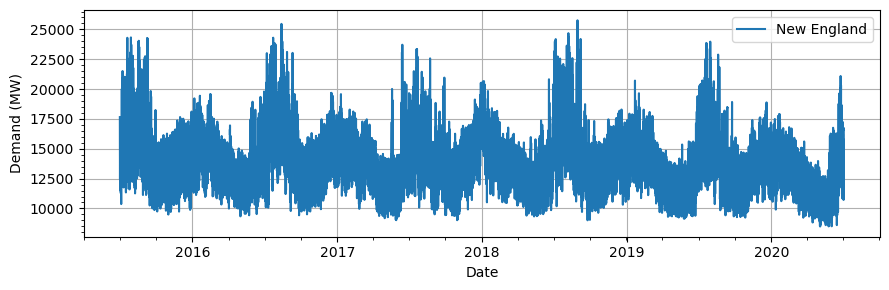

In [6]:
plt.figure(figsize=(9,3))
plt.plot(df_NE['date_time'], df_NE['cleaned_demand_MW'], label='New England')
plt.xlabel('Date')
plt.ylabel('Demand (MW)')
plt.minorticks_on()
plt.legend()

plt.grid(True)
plt.tight_layout()
plt.show()

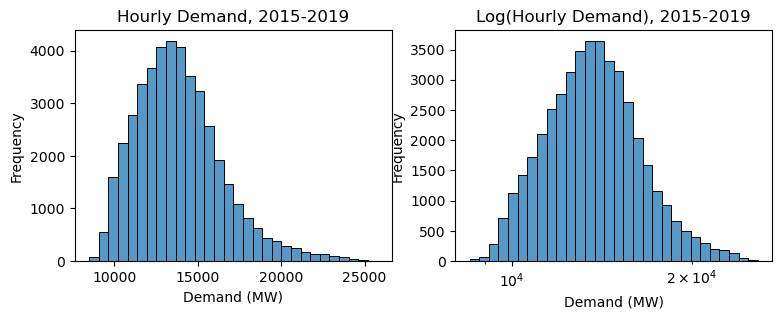

In [61]:
fig, axes = plt.subplots(1, 2, figsize=(9, 3))

sns.histplot(data=df_NE, x='cleaned_demand_MW', bins=30, ax=axes[0])
axes[0].set_xlabel('Demand (MW)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Hourly Demand, 2015-2019')

sns.histplot(data=df_NE, x='cleaned_demand_MW', bins=30, log_scale=True, ax=axes[1])
axes[1].set_xlabel('Demand (MW)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Log(Hourly Demand), 2015-2019')

plt.show()

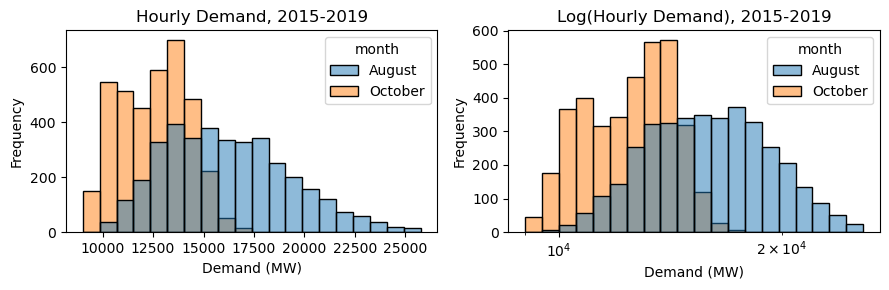

In [62]:
df_NE['month'] = df_NE['date_time'].dt.strftime('%B')

plotmonths = [8, 10]
df_seasonal = df_NE[df_NE['date_time'].dt.month.isin(plotmonths)]

fig, axes = plt.subplots(1, 2, figsize=(9, 3))

sns.histplot(data=df_seasonal, x='cleaned_demand_MW', bins=20, hue='month', ax=axes[0])
axes[0].set_xlabel('Demand (MW)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Hourly Demand, 2015-2019')

sns.histplot(data=df_seasonal, x='cleaned_demand_MW', bins=20, hue='month', log_scale=True, ax=axes[1])
axes[1].set_xlabel('Demand (MW)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Log(Hourly Demand), 2015-2019')

plt.tight_layout()
plt.show()

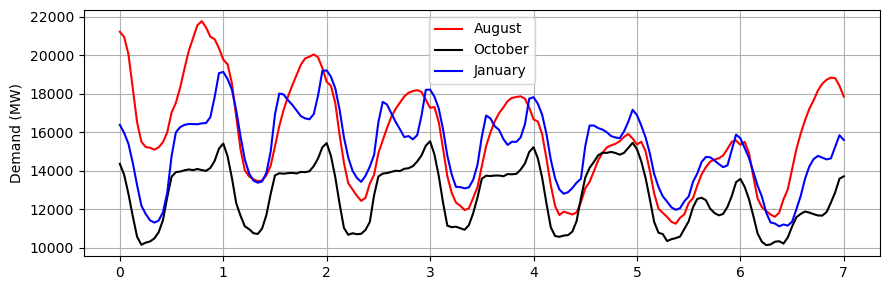

In [9]:
start_date1 = pd.to_datetime('2015-08-04 00:00:00')
end_date1 = pd.to_datetime('2015-08-11 00:00:00')

start_date2 = pd.to_datetime('2015-10-05 00:00:00')
end_date2 = pd.to_datetime('2015-10-12 00:00:00')

start_date3 = pd.to_datetime('2016-01-04 00:00:00')
end_date3 = pd.to_datetime('2016-01-11 00:00:00')

subset1 = df_NE.loc[(df_NE['date_time'] >= start_date1) & (df_NE['date_time'] <= end_date1)].copy()
subset2 = df_NE.loc[(df_NE['date_time'] >= start_date2) & (df_NE['date_time'] <= end_date2)].copy()
subset3 = df_NE.loc[(df_NE['date_time'] >= start_date3) & (df_NE['date_time'] <= end_date3)].copy()


plt.figure(figsize=(9,3))
plt.plot((subset1['date_time']-start_date1)/dt.timedelta(days=1), subset1['cleaned_demand_MW'], label='August', color='red')
plt.plot((subset2['date_time']-start_date2)/dt.timedelta(days=1), subset2['cleaned_demand_MW'], label='October', color='black')
plt.plot((subset3['date_time']-start_date3)/dt.timedelta(days=1), subset3['cleaned_demand_MW'], label='January', color='blue')
plt.ylabel('Demand (MW)')


plt.legend()

plt.grid(True)
plt.tight_layout()
plt.show()

## Cross-validation for time series

In [10]:
columns = ['date_time', 'cleaned_demand_MW']

train_start = pd.to_datetime('2015-07-02 00:00:00')
train_end = pd.to_datetime('2018-07-01 23:00:00')

val_start = pd.to_datetime('2018-07-02 00:00:00')
val_end = pd.to_datetime('2019-07-01 23:00:00')

test_start = pd.to_datetime('2019-07-02 00:00:00')
test_end = pd.to_datetime('2020-07-01 23:00:00')

df_train = df_NE.loc[(df_NE['date_time'] >= train_start) & (df_NE['date_time'] <= train_end)].copy()[columns]
df_val = df_NE.loc[(df_NE['date_time'] >= val_start) & (df_NE['date_time'] <= val_end)].copy()[columns]
df_test = df_NE.loc[(df_NE['date_time'] >= test_start) & (df_NE['date_time'] <= test_end)].copy()[columns]

In [11]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 26304 entries, 0 to 26303
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   date_time          26304 non-null  datetime64[ns]
 1   cleaned_demand_MW  26304 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 616.5 KB


## Mean Model

A good baseline is the mean model, which has a MSE equal to the variance of the data. We'll take the square root to look at RMSE. Another metric we can consider is the 𝑅<sup>2</sup> score. This will be very bad for the mean model. 

In [12]:
np.sqrt(df_val.cleaned_demand_MW.var())

2684.356183757364

In [13]:
metrics.r2_score(df_val.cleaned_demand_MW, [df_val.cleaned_demand_MW.mean()]*len(df_val.cleaned_demand_MW))

0.0

## Indicator Features Model

In [14]:
class HourofDay(base.BaseEstimator, base.TransformerMixin):
    
    def __init__(self, column_name='target', horizon=0):
        self.column_name=column_name
        self.horizon = horizon
    
    def fit(self, X, y=None):
        return self
    
    def hour_vector(self, hour):
        v = np.zeros(24)
        v[hour] = 1
        return v
    
    def transform(self, X):
        # Adjust the timestamp with the horizon offset
        adjusted_timestamp = X[self.column_name] - pd.DateOffset(hours=self.horizon)
        
        # Extract the hour of the day for the adjusted timestamp
        hour_of_day = adjusted_timestamp.dt.hour
        
        return np.stack([self.hour_vector(h) for h in hour_of_day])

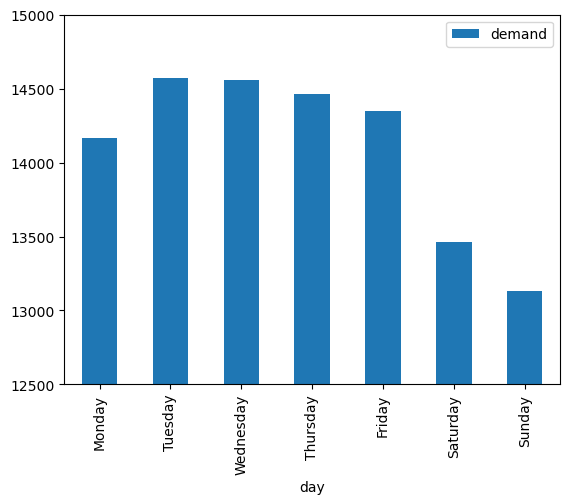

In [15]:
day_df = pd.DataFrame(
    {'day': df_train.date_time.dt.dayofweek, 'demand': df_train.cleaned_demand_MW.values}
)

ax = day_df.groupby('day').mean().plot(kind='bar')
ax.set_ylim(12500, 15000)
plt.xticks(range(7), ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']);

In [16]:
class DayofWeek(base.BaseEstimator, base.TransformerMixin):
    
    def __init__(self, column_name='target', horizon=0):
        self.column_name=column_name
        self.horizon=horizon
    
    def fit(self, X, y=None):
        return self
    
    def weekday_vector(self, weekday):
        v = np.zeros(7)
        v[weekday] = 1
        return v
    
    def transform(self, X):
        # Adjust the timestamp with the horizon offset
        adjusted_timestamp = X[self.column_name] - pd.DateOffset(hours=self.horizon)
        
        # Extract the day of the week for the adjusted timestamp
        day_of_week = adjusted_timestamp.dt.dayofweek
        
        return np.stack([self.weekday_vector(d) for d in day_of_week])

In [17]:
class MonthofYear(base.BaseEstimator, base.TransformerMixin):
    
    def __init__(self, column_name='target', horizon=0):
        self.column_name=column_name
        self.horizon=horizon
    
    def fit(self, X, y=None):
        return self
    
    def month_vector(self, month):
        v = np.zeros(12)
        v[month-1] = 1
        return v
    
    def transform(self, X):
        # Adjust the timestamp with the horizon offset
        adjusted_timestamp = X[self.column_name] - pd.DateOffset(hours=self.horizon)
        
        # Extract the hour of the day for the adjusted timestamp
        month_of_year = adjusted_timestamp.dt.month
        
        return np.stack([self.month_vector(m) for m in month_of_year])

In [63]:
union = FeatureUnion([('monthofyear', MonthofYear(column_name='date_time')),
                      ('dayofweek', DayofWeek(column_name='date_time')),
                      ('hourofday',HourofDay(column_name='date_time'))])
indicator_pipe = Pipeline([('union', union),
                 ('lr', LinearRegression())])

In [64]:
y_train = np.log1p(df_train.cleaned_demand_MW.values)

In [65]:
indicator_model = indicator_pipe.fit(df_train, y_train)

In [68]:
y_train_base_pred = np.expm1(indicator_model.predict(df_train))
y_val_base_pred = np.expm1(indicator_model.predict(df_val))

In [69]:
def plot_demand_actual_vs_predicted(df, actual_column, predicted_data, start_date, end_date):
    plt.figure(figsize=(9, 3))
    plt.plot(df['date_time'], df[actual_column], label='Actual')
    plt.plot(df['date_time'], predicted_data, label='Predicted')
    plt.xlim([pd.to_datetime(start_date), pd.to_datetime(end_date)])
    plt.xlabel('Date')
    plt.ylabel('Demand (MW)')
    plt.minorticks_on()
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

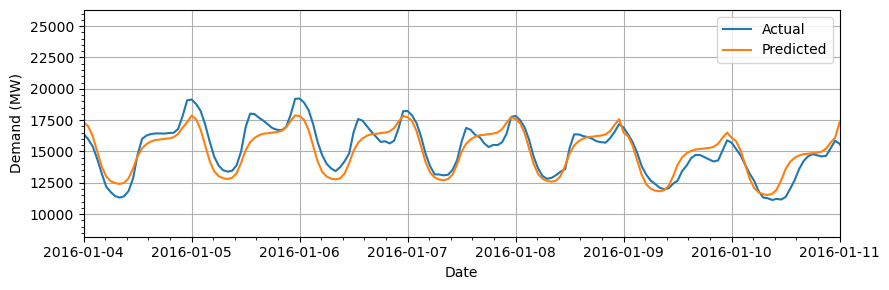

In [70]:
plot_demand_actual_vs_predicted(df_train, 'cleaned_demand_MW', y_train_base_pred,
                                '2016-01-04 00:00:00', '2016-01-11 00:00:00')

In [71]:
print("RMSE:", np.sqrt(metrics.mean_squared_error(df_train.cleaned_demand_MW.astype('float64'),
                                                  y_train_base_pred)))
print("R^2:", metrics.r2_score(df_train.cleaned_demand_MW.astype('float64'), y_train_base_pred))

RMSE: 1449.0711082323817
R^2: 0.678559768919281


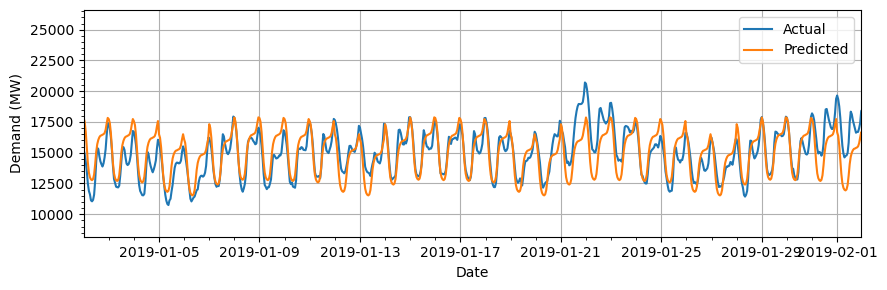

In [72]:
plot_demand_actual_vs_predicted(df_val, 'cleaned_demand_MW', y_val_base_pred, 
                                '2019-01-02 00:00:00', '2019-02-01 23:00:00')

In [73]:
print("RMSE:", np.sqrt(metrics.mean_squared_error(df_val.cleaned_demand_MW.astype('float64'),
                                                  y_val_base_pred)))
print("R^2:", metrics.r2_score(df_val.cleaned_demand_MW.astype('float64'), y_val_base_pred))

RMSE: 1536.1003042146494
R^2: 0.6725021542676921


## Modeling the "noise"

In [74]:
df_train['base_demand'] = y_train_base_pred
df_train['demand_anomaly'] = df_train['cleaned_demand_MW'] - df_train['base_demand']

df_val['base_demand'] = y_val_base_pred
df_val['demand_anomaly'] = df_val['cleaned_demand_MW'] - df_val['base_demand']

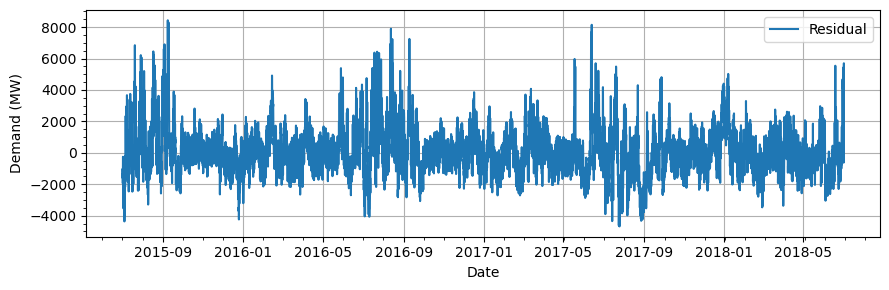

In [75]:
plt.figure(figsize=(9,3))
plt.plot(df_train['date_time'], df_train['demand_anomaly'], label='Residual')
#plt.xlim([pd.to_datetime('2016-01-04 00:00:00'), pd.to_datetime('2016-01-11 00:00:00')])
plt.xlabel('Date')
plt.ylabel('Demand (MW)')
plt.minorticks_on()
plt.legend()

plt.grid(True)
plt.tight_layout()
plt.show()

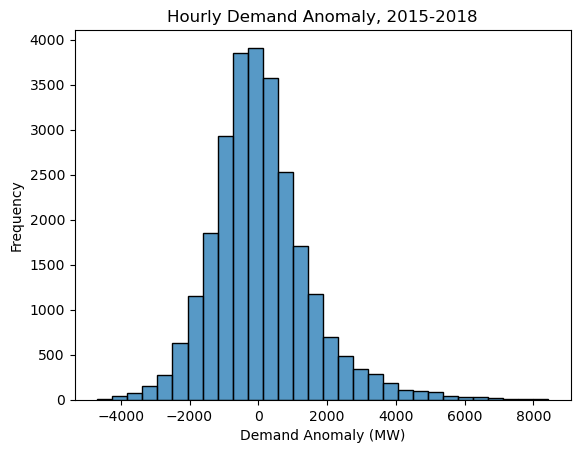

In [76]:
sns.histplot(data=df_train, x='demand_anomaly', bins=30)
plt.xlabel('Demand Anomaly (MW)')
plt.ylabel('Frequency')
plt.title('Hourly Demand Anomaly, 2015-2018')
plt.show()

In [77]:
df_train.demand_anomaly.describe()

count    26304.000000
mean        69.059055
std       1447.452097
min      -4683.038076
25%       -814.034004
50%        -66.633551
75%        757.831480
max       8433.066560
Name: demand_anomaly, dtype: float64

In [78]:
np.sqrt(df_val.demand_anomaly.var())

1527.6325171956

In [79]:
metrics.r2_score(df_val.demand_anomaly, [df_val.demand_anomaly.mean()]*len(df_val.demand_anomaly))

0.0

### Autocorrelation

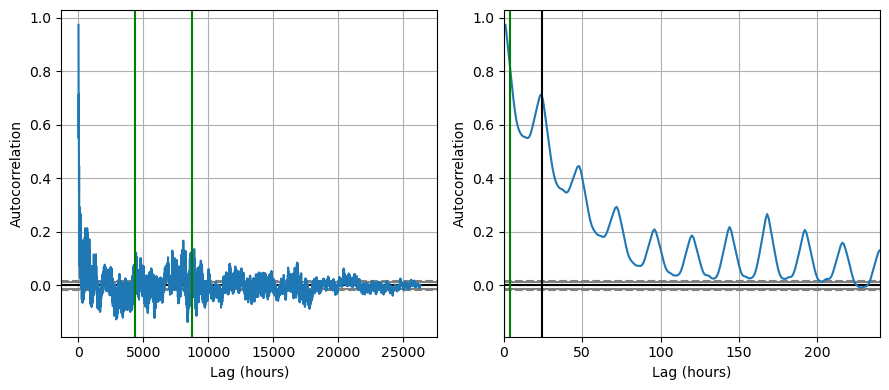

In [80]:
from pandas.plotting import autocorrelation_plot

fig, axes = plt.subplots(1, 2, figsize=(9, 4))

autocorrelation_plot(df_train['demand_anomaly'], ax=axes[0])
axes[0].set_xlabel('Lag (hours)')
axes[0].axvline(24*182, color = 'green')
axes[0].axvline(24*365, color = 'green')

autocorrelation_plot(df_train['demand_anomaly'], ax=axes[1])
axes[1].set_xlabel('Lag (hours)')
axes[1].axvline(4, color = 'green')
axes[1].axvline(24, color = 'black')
plt.xlim([0, 240])

plt.tight_layout()
plt.show();

In [81]:
df_train.head()

date_time  cleaned_demand_MW   base_demand  demand_anomaly  \
0 2015-07-02 00:00:00              17653  19053.756253    -1400.756253   
1 2015-07-02 01:00:00              17286  18719.450711    -1433.450711   
2 2015-07-02 02:00:00              16701  17849.100265    -1148.100265   
3 2015-07-02 03:00:00              15220  16514.698807    -1294.698807   
4 2015-07-02 04:00:00              13594  15196.340622    -1602.340622   

   predicted_anomaly  predicted_demand  
0       -1107.269188      17696.730812  
1       -1107.269188      17404.730812  
2       -1221.504635      16553.495365  
3        -937.120383      15707.879617  
4       -1596.199117      13925.800883

### Feature Engineering

In [82]:
class LagTransformer(base.BaseEstimator, base.TransformerMixin):
    def __init__(self, column_name='label', lag=1):
        self.lag=lag
        self.column_name=column_name
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # Create a copy of the input DataFrame to avoid altering the original
        X_copy = X.copy()
        
        # Shift the specified column by 'lag' rows
        if self.lag <= len(X) - 1:
            X_copy[f'{self.column_name}-{self.lag}'] = X_copy[self.column_name].shift(self.lag)
            X_copy[f'{self.column_name}-{self.lag}'] = X_copy[f'{self.column_name}-{self.lag}'].fillna(method='bfill', axis=0)
            return X_copy[[f'{self.column_name}-{self.lag}']]
        else:
            print(f'Requested shift {self.lag} > number of records. Returning {self.column_name}-{len(X_copy)-1}')
            X_copy[f'{self.column_name}-{len(X_copy)-1}'] = X_copy[self.column_name].shift(len(X_copy) - 1)
            X_copy[f'{self.column_name}-{len(X_copy)-1}'] = X_copy[f'{self.column_name}-{len(X_copy)-1}'].fillna(method='bfill', axis=0)
            return X_copy[f'{self.column_name}-{len(X_copy)-1}']


# create a future demand target dataframe
def make_future_value(df, target_list, horizonlist):
    #accepts dataframe, target column (string) and horizon(+integer), adds prediction column to dataframe
    future = pd.DataFrame()
    future['date_time'] = df['date_time']
    
    for target in target_list:
        future[target] = df[target]
        for horizon in horizonlist:
            future[f'{target}_plus{horizon}'] = df[target].shift(-(horizon)).fillna(method='ffill')
    
    return future

In [83]:
union = FeatureUnion([('lag_1', LagTransformer(column_name='demand_anomaly', lag=1)),
                      ('lag_2', LagTransformer(column_name='demand_anomaly', lag=2)),
                      ('lag_3', LagTransformer(column_name='demand_anomaly', lag=3)),
                      ('lag_4', LagTransformer(column_name='demand_anomaly', lag=4))])

residual_pipe = Pipeline([('union', union),
                 ('lr', LinearRegression())])

In [84]:
residual_model = residual_pipe.fit(df_train, df_train.demand_anomaly.astype('float64'))

In [85]:
y_train_resid_pred = residual_model.predict(df_train)
y_val_resid_pred = residual_model.predict(df_val)

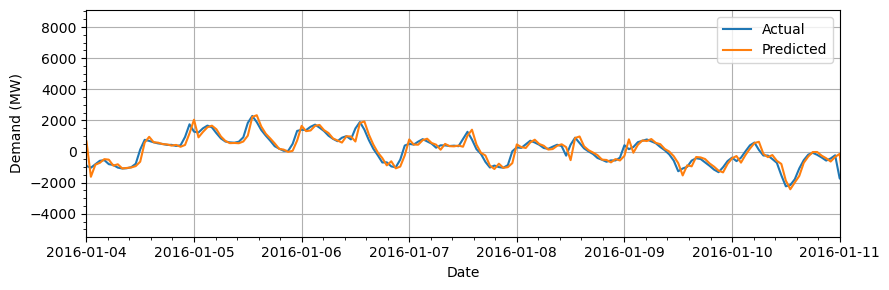

In [86]:
plot_demand_actual_vs_predicted(df_train, 'demand_anomaly', y_train_resid_pred,
                                '2016-01-04 00:00:00', '2016-01-11 00:00:00')

In [87]:
print("RMSE:", np.sqrt(metrics.mean_squared_error(df_train.demand_anomaly.astype('float64'),
                                                  y_train_resid_pred)))
print("R^2:", metrics.r2_score(df_train.demand_anomaly.astype('float64'), y_train_resid_pred))

RMSE: 292.59639941734486
R^2: 0.9591355115881889


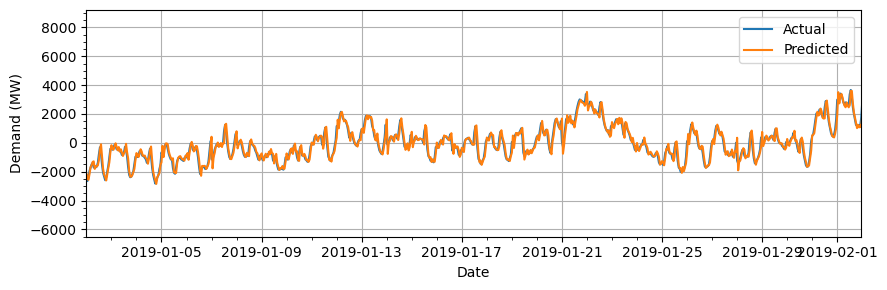

In [88]:
plot_demand_actual_vs_predicted(df_val, 'demand_anomaly', y_val_resid_pred,
                                '2019-01-02 00:00:00', '2019-02-01 23:00:00')

In [89]:
print("RMSE:", np.sqrt(metrics.mean_squared_error(df_val.demand_anomaly.astype('float64'),
                                                  y_val_resid_pred)))
print("R^2:", metrics.r2_score(df_val.demand_anomaly.astype('float64'), y_val_resid_pred))

RMSE: 296.9900744072968
R^2: 0.9621996638644379


In [90]:
df_train['predicted_anomaly'] = y_train_resid_pred
df_train['predicted_demand'] = df_train.base_demand + df_train['predicted_anomaly']

In [91]:
df_train.head()

date_time  cleaned_demand_MW   base_demand  demand_anomaly  \
0 2015-07-02 00:00:00              17653  19053.756253    -1400.756253   
1 2015-07-02 01:00:00              17286  18719.450711    -1433.450711   
2 2015-07-02 02:00:00              16701  17849.100265    -1148.100265   
3 2015-07-02 03:00:00              15220  16514.698807    -1294.698807   
4 2015-07-02 04:00:00              13594  15196.340622    -1602.340622   

   predicted_anomaly  predicted_demand  
0       -1345.800799      17707.955454  
1       -1345.800799      17373.649912  
2       -1394.239006      16454.861259  
3        -950.328634      15564.370173  
4       -1358.140309      13838.200312

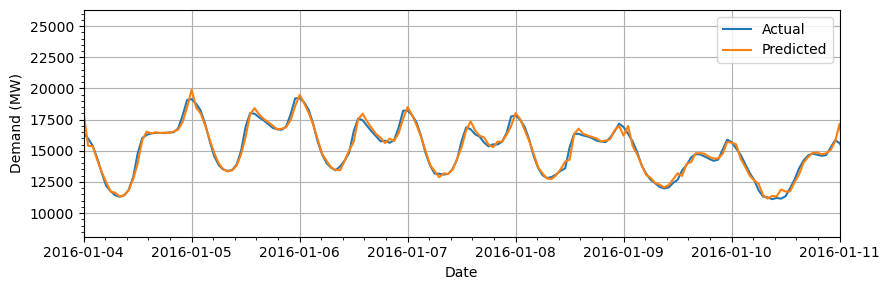

In [92]:
plot_demand_actual_vs_predicted(df_train, 'cleaned_demand_MW', df_train['predicted_demand'],
                                '2016-01-04 00:00:00', '2016-01-11 00:00:00')

In [93]:
print("RMSE:", np.sqrt(metrics.mean_squared_error(df_train.cleaned_demand_MW.astype('float64'),
                                                  df_train.predicted_demand.astype('float64'))))
print("R^2:", metrics.r2_score(df_train.cleaned_demand_MW.astype('float64'),
                                                  df_train.predicted_demand.astype('float64')))

RMSE: 292.5963994173449
R^2: 0.9868943431739501


In [94]:
df_val['predicted_anomaly'] = y_val_resid_pred
df_val['predicted_demand'] = df_val.base_demand + df_val['predicted_anomaly']

In [95]:
df_val.head()

date_time  cleaned_demand_MW   base_demand  demand_anomaly  \
26304 2018-07-02 00:00:00              22008  18615.761819     3392.238181   
26305 2018-07-02 01:00:00              21444  18289.140655     3154.859345   
26306 2018-07-02 02:00:00              20695  17438.796168     3256.203832   
26307 2018-07-02 03:00:00              19005  16135.067388     2869.932612   
26308 2018-07-02 04:00:00              17439  14847.013109     2591.986891   

       predicted_anomaly  predicted_demand  
26304        3268.386249      21884.148068  
26305        3268.386249      21557.526905  
26306        2916.699571      20355.495738  
26307        3220.418404      19355.485792  
26308        2538.928064      17385.941173

In [96]:
print("RMSE:", np.sqrt(metrics.mean_squared_error(df_val.cleaned_demand_MW.astype('float64'),
                                                  df_val.predicted_demand.astype('float64'))))
print("R^2:", metrics.r2_score(df_val.cleaned_demand_MW.astype('float64'),
                                                  df_val.predicted_demand.astype('float64')))

RMSE: 296.9900744072968
R^2: 0.9877579776633318


### Forecasting

### Putting it all together

Code to:

* take in a dataframe with hourly timestamps and measured demand values,
* take a parameter for forecast horizon,
* train an indicator features model for current base demand (seasonal)
* subtract current base demand from current demand to find current anomaly (random),
* shift the demand signal to match the desired forecast horizon to use as training target,
* train a model of lag features on the anomaly at the forecast horizon
* use the indicator model to predict base demand at horizon,
* use the resdiduals model to predict the anomaly at the horizon,
* add predicted base demand to predicted anomaly to get the predicted demand


In [97]:
df_train_plus2 = make_future_value(df_train, ['date_time', 'cleaned_demand_MW'], [2])
df_train_plus2.tail()

date_time     date_time_plus2  cleaned_demand_MW  \
26299 2018-07-01 19:00:00 2018-07-01 21:00:00              21095   
26300 2018-07-01 20:00:00 2018-07-01 22:00:00              21568   
26301 2018-07-01 21:00:00 2018-07-01 23:00:00              22068   
26302 2018-07-01 22:00:00 2018-07-01 23:00:00              22517   
26303 2018-07-01 23:00:00 2018-07-01 23:00:00              22498   

       cleaned_demand_MW_plus2  
26299                  22068.0  
26300                  22517.0  
26301                  22498.0  
26302                  22498.0  
26303                  22498.0

In [98]:
df_train = df_train[['date_time', 'cleaned_demand_MW']]
df_val = df_val[['date_time', 'cleaned_demand_MW']]

In [99]:
df_test.head()

date_time  cleaned_demand_MW
35064 2019-07-02 00:00:00              17918
35065 2019-07-02 01:00:00              17400
35066 2019-07-02 02:00:00              16700
35067 2019-07-02 03:00:00              15190
35068 2019-07-02 04:00:00              13623